# **<h3 align="center">Machine Learning - Project</h3>**
## **<h3 align="center">4. Level 2 Multi-Class Classification</h3>**
### **<h3 align="center">Group 30 - Project</h3>**


### Group Members
| Name              | Email                        | Student ID |
|-------------------|------------------------------|------------|
| Alexandra Pinto   | 20211599@novaims.unl.pt      | 20211599   |
| Gonçalo Peres     | 20211625@novaims.unl.pt      | 20211625   |
| Leonor Mira       | 20240658@novaims.unl.pt      | 20240658   |
| Miguel Natário    | 20240498@novaims.unl.pt      | 20240498   |
| Nuno Bernardino   | 20211546@novaims.unl.pt      | 20211546    |

---

### **4. Level 2 Multi-Class Classification Notebook**
**Description:**
This notebook handles the **Level 2 Multi-Class Classification model**, which processes cases classified as "Other" in Level 1 and assigns them to their specific class among the rarer categories.

Key steps include:
- Loading the subset of “**Other**” cases from Level 1 predictions.
- **Feature selection:** Focus on features relevant for differentiating between the rare classes.
- **Model training:** Train and evaluate a multi-class classification model to predict the specific class of these cases.
- **Evaluation:** Use multi-class metrics like accuracy, macro-averaged F1-score, and confusion matrices.
- **Output:** Save predictions for merging in the final pipeline.

This notebook specializes in handling the complexity of rare classes, ensuring that all cases are correctly classified.

---

## Table of Contents
* [1. Import the Libraries](#chapter1)
* [2. Load and Prepare Datasets](#chapter2)
* [3. Setting the Target](#chapter3)
* [4. Feature Selection](#chapter4)
    * [Scaling the Data](#section_4_1)  
    * [Numerical Features](#section_4_2) 
    * [Categorical Features](#section_4_3) 
    * [Final Features](#section_4_3)
* [5. Modelling](#chapter5)
* [6. Loading the results](#chapter6)


# 1. Import the Libraries 📚<a class="anchor" id="chapter1"></a>

In [1]:
# --- Standard Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import zipfile


# --- Scikit-Learn Modules for Data Partitioning and Preprocessing ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


# --- Feature Selection Methods ---
# Filter Methods
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest

# Wrapper Methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Embedded Methods
from sklearn.linear_model import LassoCV

# --- Evaluation Metrics ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

#from xgboost import XGBClassifier

# --- Warnings ---


import warnings
warnings.filterwarnings('ignore')


#selecionar apenas as função que vamos usar neste :)
from utils import plot_importance, cor_heatmap, find_optimal_features_with_rfe, compare_rf_feature_importances,compare_feature_importances, select_high_score_features_chi2_no_model,select_high_score_features_MIC, metrics

# 2. Load and Prepare Datasets 📁<a class="anchor" id="chapter2"></a>

In [2]:
# Caminho para os arquivos
X_train_path = r'C:\Users\migue\Downloads\Data-Mining-24-25-main\Data-Mining-24-25-main\Data_Temporary\X_train_processed.csv'
X_val_path = r'C:\Users\migue\Downloads\Data-Mining-24-25-main\Data-Mining-24-25-main\Data_Temporary\X_val_processed.csv'
best_xgb_path = r'C:\Users\migue\Downloads\Data-Mining-24-25-main\Data-Mining-24-25-main\Data_Temporary\best_xgb_test_predictions.csv'

# Importar os arquivos
X_train = pd.read_csv(X_train_path, index_col='Claim Identifier')
X_val = pd.read_csv(X_val_path, index_col='Claim Identifier')
df_test = pd.read_csv(best_xgb_path)

In [3]:
import numpy as np

# Caminhos para os arquivos
y_train_path = r"C:\Users\migue\Downloads\Data-Mining-24-25-main\Data-Mining-24-25-main\Data_Temporary\y_train.npy"
y_val_path = r"C:\Users\migue\Downloads\Data-Mining-24-25-main\Data-Mining-24-25-main\Data_Temporary\y_val.npy"

# Carregar os arrays com allow_pickle=True
y_train = np.load(y_train_path, allow_pickle=True)
y_val = np.load(y_val_path, allow_pickle=True)

In [4]:
pd.set_option('display.max_columns', None)  # Mostra todas as colunas
pd.set_option('display.width', 1000)       # Ajusta a largura máxima da exibição
pd.set_option('display.max_rows', 50) 

In [5]:
y_train_encoded = np.array([int(item.split('.')[0]) for item in y_train])
y_val_encoded = np.array([int(item.split('.')[0]) for item in y_val])

In [61]:
# Removendo a coluna 'Predictions' do DataFrame df_test e armazenando em y_test
y_test = df_test['Predictions']
df_test.drop('Predictions', axis=1, inplace=True)

# 4. Feature Selection <a class="anchor" id="chapter4"></a>

The feature selection process involves summarizing the essential features in the dataset to help the model focus on the most relevant information. Here, we assess the categorical and numerical variables in `X_train_processed` by examining unique values, descriptive statistics, and verifying the correctness of categorical bins and continuous feature distributions.

The `X_train_processed.describe(include='O').T` command provides an overview of the categorical features in the dataset, displaying the count, unique values, top (most frequent) category, and its frequency. This summary helps us understand the distribution and cardinality of each categorical feature, which is essential for feature selection and preprocessing.

#### Descriptive Statistics for Categorical Features

In [6]:
# Displaying descriptive statistics for categorical features in the training dataset
X_train.describe(include='O').T

,count,unique,top,freq
Carrier Name,398994,1960,STATE INSURANCE FUND,77168
Carrier Type,398994,8,PRIVATE,198800
County of Injury,398994,63,SUFFOLK,41965
District Name,398994,8,NYC,188402
Gender,398994,3,M,232838
Medical Fee Region,398994,5,IV,185033
Zip Code,398993,9088,11236,3849
Category Combination,398994,22,PRIVATE-M,115379
Carrier_District_Interaction,398994,52,PRIVATE_NYC,92172
Income_Category,398994,5,Lower-Middle Income,100196


This table provides insight into the number of unique categories within each feature, assisting in identifying high-cardinality features that may need simplification or encoding before modeling.

The next output explores the Income_Category feature specifically, showing its categorical distribution across different income levels.

In [7]:
# Exploring the distribution of Income_Category
X_train['Income_Category'].value_counts()

Income_Category
Lower-Middle Income    100196
Low Income              99749
Upper-Middle Income     99301
High Income             70267
Upper-High Income       29481
Name: count, dtype: int64

The `Income_Category` feature categorizes the `Average Weekly Wage` into four levels:
- **Low Income**
- **Lower-Middle Income**
- **Upper-Middle Income**
- **High Income**

This feature provides a socioeconomic context for the claims, allowing the model to account for income-based disparities in claims.

#### Descriptive Statistics for Numerical Features

In [8]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age at Injury,398994.0,42.908502,12.927821,16.000000,32.0000,43.000000,53.000000,80.00
Attorney/Representative,398994.0,0.315416,0.464682,0.000000,0.0000,0.000000,1.000000,1.00
Average Weekly Wage,398994.0,1244.287122,7036.370387,17.410000,869.8025,1198.087381,1489.970000,2828079.00
Birth Year,398994.0,1977.938823,13.038683,1918.101209,1968.0000,1978.101209,1988.000000,2006.00
COVID-19 Indicator,398994.0,0.048367,0.214540,0.000000,0.0000,0.000000,0.000000,1.00
IME-4 Count,398994.0,0.747054,1.928570,0.000000,0.0000,0.000000,0.000000,73.00
Industry Code,398994.0,14.794842,6.791442,-1.000000,9.0000,18.000000,19.000000,23.00
WCIO Cause of Injury Code,398994.0,53.315619,26.733636,0.000000,29.0000,56.000000,75.000000,99.00
WCIO Nature of Injury Code,398994.0,40.191752,22.733837,0.000000,13.0000,49.000000,52.000000,91.00
WCIO Part Of Body Code,398994.0,46.939114,23.969010,0.000000,35.0000,42.000000,55.000000,101.00


These features provide comprehensive information across demographics, injury details, socioeconomics, and temporal aspects, making them well-suited to predicting claim outcomes.

In [9]:
X_train.columns

Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage', 'Birth Year', 'Carrier Name', 'Carrier Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender', 'IME-4 Count', 'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code', 'Number of Dependents', 'Category Combination', 'Carrier_District_Interaction', 'Income_Category', 'Days_To_First_Hearing', 'Accident_Quarter', 'Accident_Year', 'Accident Day', 'Accident on Weekend', 'Age Group', 'promptness_category', 'promptness_C2_category', 'promptness_C3_category', 'Zip_Code_Simplified', 'Carrier Type Merged', 'Carrier_Name_Simplified', 'Body_Part_Category', 'Injury_Nature_Category', 'Injury_Cause_Category', 'Industry Risk', 'Salary_Per_Dependent'], dtype='object')

#### Analysis of `Age Group`

In [10]:
X_train['Age Group']

Claim Identifier
5479022          Youth
6023025    Young Adult
5851908    Young Adult
5913931     Middle Age
5845976     Middle Age
              ...     
5655355         Senior
5940234    Young Adult
6073417     Middle Age
5822576    Young Adult
5566085    Young Adult
Name: Age Group, Length: 398994, dtype: object

This feature allows the model to understand age-related variations in claims, which could influence the type and nature of injuries.

This structured feature selection summary provides insights into the main features, both categorical and numerical, used in the model. The focus on grouping, simplification, and categorization ensures the model captures the relevant patterns without unnecessary complexity.


### Feature Categories
The features have been organized into three main categories: **Categorical Features**, **Binary Features**, and **Discrete Features**. Each category represents a different data type or structure, allowing for tailored preprocessing steps and analysis.

In [11]:
X_train.columns

Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage', 'Birth Year', 'Carrier Name', 'Carrier Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender', 'IME-4 Count', 'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code', 'Number of Dependents', 'Category Combination', 'Carrier_District_Interaction', 'Income_Category', 'Days_To_First_Hearing', 'Accident_Quarter', 'Accident_Year', 'Accident Day', 'Accident on Weekend', 'Age Group', 'promptness_category', 'promptness_C2_category', 'promptness_C3_category', 'Zip_Code_Simplified', 'Carrier Type Merged', 'Carrier_Name_Simplified', 'Body_Part_Category', 'Injury_Nature_Category', 'Injury_Cause_Category', 'Industry Risk', 'Salary_Per_Dependent'], dtype='object')

In [12]:
# Updating the feature categories with the new columns created
categorical_columns = ['Carrier Name', 'Carrier Type', 'County of Injury',
       'District Name', 'Gender', 'IME-4 Count',
       'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code',
    'Carrier_District_Interaction',
       'Income_Category', 'Age Group',
       'promptness_category', 'promptness_C2_category','promptness_C3_category', 'Zip_Code_Simplified',
       'Carrier Type Merged', 'Carrier_Name_Simplified', 'Body_Part_Category',
       'Injury_Nature_Category', 'Injury_Cause_Category', 'Industry Risk',
]

binary_columns = [
    'Attorney/Representative', 'COVID-19 Indicator',
     'Accident on Weekend'
]

discrete_columns = [ 'Number of Dependents', 'IME-4 Count',
    'Accident_Quarter', 'Accident_Year', 'Accident Day'
]

continuous_columns = ['Days_To_First_Hearing','Average Weekly Wage','Age at Injury',
                      'Salary_Per_Dependent'
                      ]

# Printing the feature categories
print("Categorical Features:", categorical_columns)
print("Binary Features:", binary_columns)
print("Discrete Features:", discrete_columns)
print("Continuous Features:", continuous_columns)

Categorical Features: ['Carrier Name', 'Carrier Type', 'County of Injury', 'District Name', 'Gender', 'IME-4 Count', 'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code', 'Carrier_District_Interaction', 'Income_Category', 'Age Group', 'promptness_category', 'promptness_C2_category', 'promptness_C3_category', 'Zip_Code_Simplified', 'Carrier Type Merged', 'Carrier_Name_Simplified', 'Body_Part_Category', 'Injury_Nature_Category', 'Injury_Cause_Category', 'Industry Risk']
Binary Features: ['Attorney/Representative', 'COVID-19 Indicator', 'Accident on Weekend']
Discrete Features: ['Number of Dependents', 'IME-4 Count', 'Accident_Quarter', 'Accident_Year', 'Accident Day']
Continuous Features: ['Days_To_First_Hearing', 'Average Weekly Wage', 'Age at Injury', 'Salary_Per_Dependent']


## 4.1. Preparing Data</b> <a class="anchor" id="section_4_1"></a>
### Converting Discrete Columns to Integer
In this step, we ensure all discrete columns are converted to integer data types across the training, validation, and test datasets. This is crucial for consistent data handling and processing in subsequent steps.

In [13]:
# Convert discrete columns to integer
for column in discrete_columns:
    X_train[column] = X_train[column].astype(int)
    X_val[column] = X_val[column].astype(int)
    df_test[column] = df_test[column].astype(int)

### Scaling Features
We apply the RobustScaler to the discrete columns. RobustScaler is beneficial for data containing outliers, as it scales data based on the median and interquartile range. This helps normalize the distribution without being heavily affected by outliers. We also use the same scaler to transform validation and test data.

In [14]:
#scaling features
from sklearn.preprocessing import MinMaxScaler
feat_scaler = MinMaxScaler()
X_train[discrete_columns + continuous_columns] = feat_scaler.fit_transform(X_train[discrete_columns + continuous_columns])

X_train_num_scaled = X_train[discrete_columns + continuous_columns]

#apply same transformation for val data
X_val[discrete_columns + continuous_columns] = feat_scaler.transform(X_val[discrete_columns + continuous_columns])

X_val_num_scaled = X_val[discrete_columns + continuous_columns]

#apply same transformation for test data
df_test[discrete_columns + continuous_columns] = feat_scaler.transform(df_test[discrete_columns + continuous_columns])
df_test_num_scaled = df_test[discrete_columns + continuous_columns]

#X_val, X_train
X_train_num_scaled.head(4)

,Number of Dependents,IME-4 Count,Accident_Quarter,Accident_Year,Accident Day,Days_To_First_Hearing,Average Weekly Wage,Age at Injury,Salary_Per_Dependent
Claim Identifier,,,,,,,,,
5479022,0.500000,0.000000,0.333333,0.951613,0.166667,0.025765,0.000282,0.125000,0.000284
6023025,0.333333,0.054795,0.333333,0.983871,0.166667,0.032369,0.000382,0.312500,0.000512
5851908,0.500000,0.027397,0.333333,0.967742,0.333333,0.065869,0.000214,0.390625,0.000216
5913931,0.166667,0.027397,0.000000,0.983871,0.500000,0.042663,0.000362,0.671875,0.000732


### Variance Check After Scaling
After scaling, we check the variance of each scaled feature to confirm that the features have been scaled properly. Lower variance after scaling indicates that data is normalized and less affected by magnitude differences.

In [15]:
# Check variance of scaled data
X_train_num_scaled.var()

Number of Dependents     0.111200
IME-4 Count              0.000698
Accident_Quarter         0.140603
Accident_Year            0.000853
Accident Day             0.092262
Days_To_First_Hearing    0.000249
Average Weekly Wage      0.000006
Age at Injury            0.040803
Salary_Per_Dependent     0.000008
dtype: float64

The output shows the variance of each discrete column in the scaled training set. These values help validate that the scaling process has achieved a consistent data distribution across features.

 ## 4.2. Numerical Features</b> <a class="anchor" id="section_4_2"></a>

 > ### 4.2.1. Spearman and Pearson correlation matrix <a class="anchor" id="sub_section_4_2_1"></a>

To better understand the relationships between numerical features, we generate Spearman and Pearson correlation matrices. Correlation matrices help identify linear and monotonic relationships between variables, which can be useful in feature selection and engineering.

##### Correlation Heatmap Function
The `cor_heatmap` function displays a heatmap of a given correlation matrix. We set various visual parameters to enhance readability:
- **figsize**: Sets the figure size.
- **cmap**: Chooses the color palette ('viridis').
- **mask**: Hides the upper triangle of the matrix for clarity.

In [16]:
from utils import cor_heatmap

#### Spearman Correlation Calculation and Plotting
Here, we calculate the Spearman correlation on the scaled numerical features and then plot the resulting matrix.

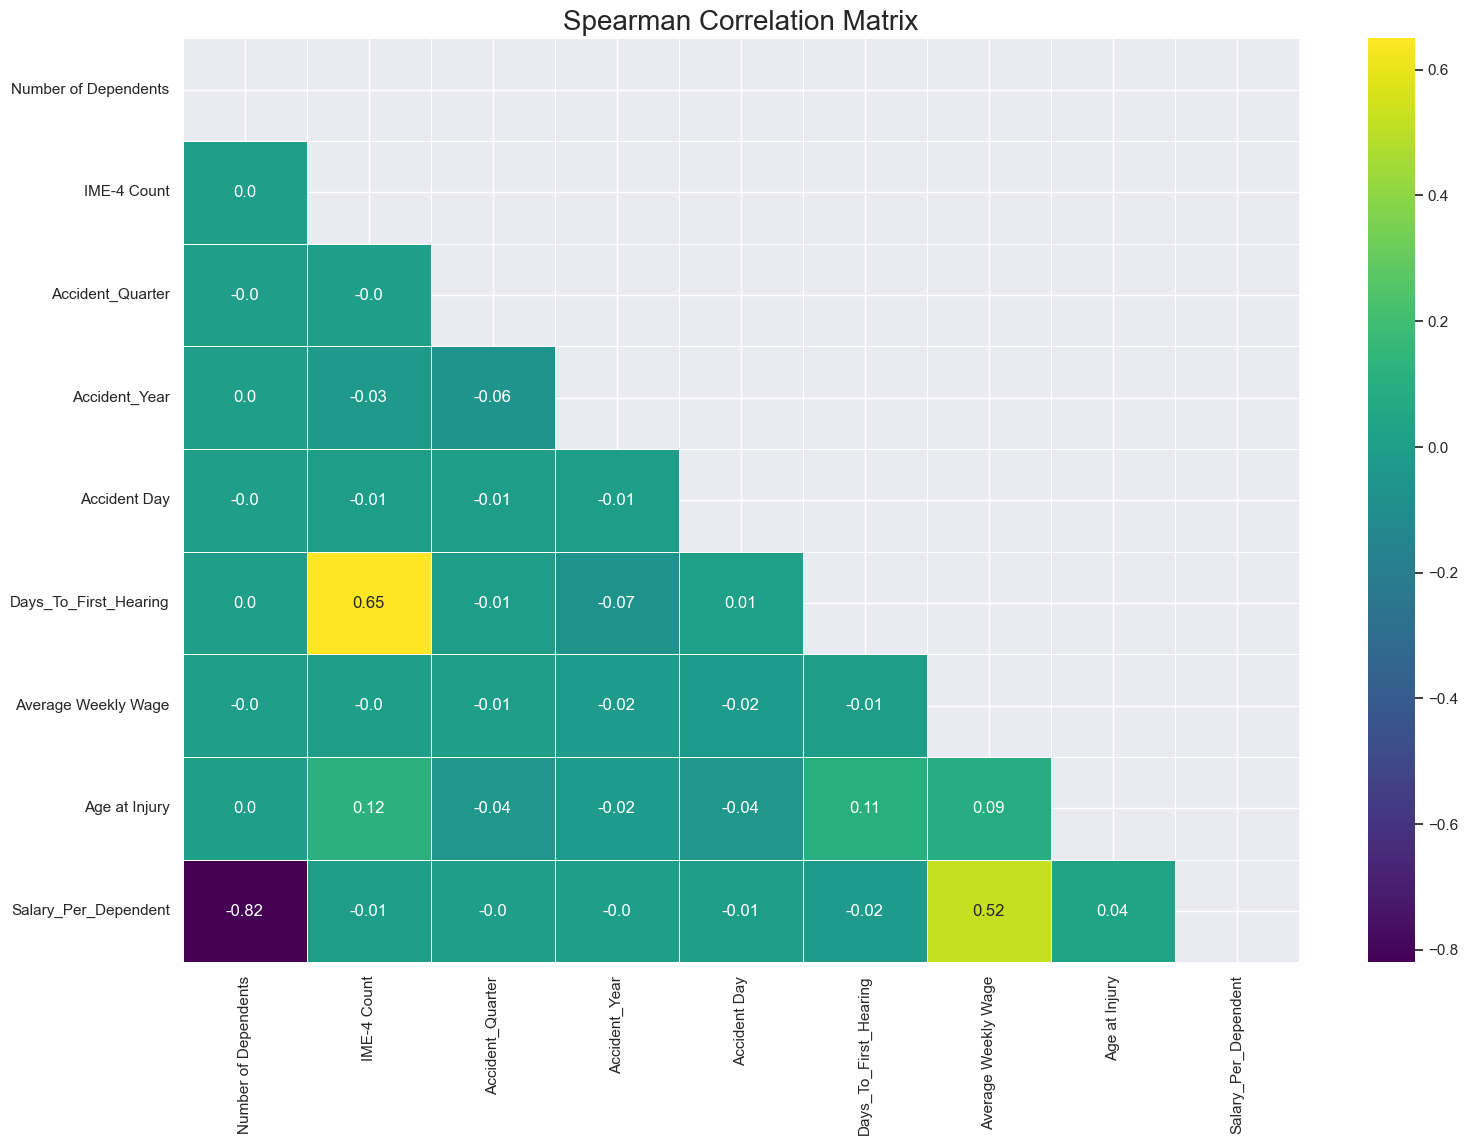

In [17]:
corr_data_numerical = X_train_num_scaled 
cor_spearman = corr_data_numerical.corr(method='spearman')

cor_heatmap(cor_spearman, 'Spearman')

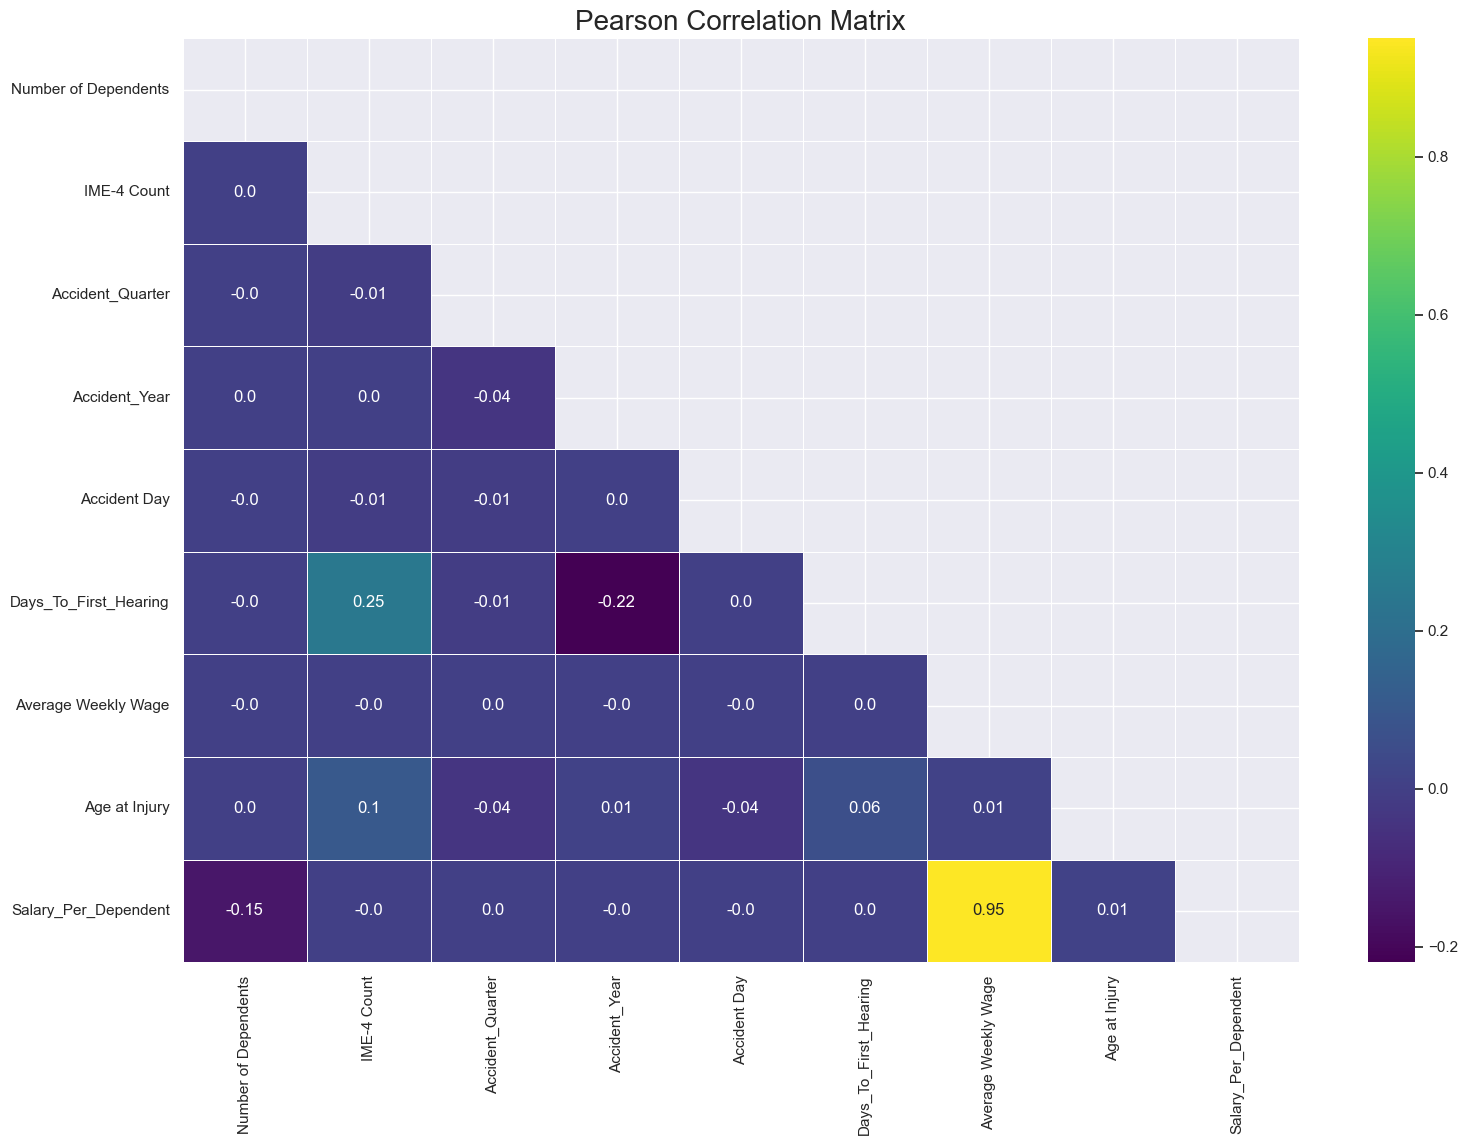

In [18]:
cor_pearson = corr_data_numerical.corr(method='pearson')

cor_heatmap(cor_pearson, 'Pearson')

> ### 4.2.2. LASSO Regression <a class="anchor" id="sub_section_4_2_2"></a>

 The LASSO (Least Absolute Shrinkage and Selection Operator) regression is used here for feature selection by fitting a model to the standardized dataset and analyzing the coefficients.

In [19]:
# Fit regression
reg = LassoCV().fit(X_train_num_scaled, y_train_encoded)
#get coefficients
coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)
# Sort coefficients to observe importance
coef.sort_values()

Accident_Quarter         -0.026670
Accident Day             -0.006687
Number of Dependents     -0.001388
Average Weekly Wage       0.000000
Age at Injury             0.296662
Accident_Year             0.595072
Salary_Per_Dependent      0.807858
Days_To_First_Hearing    14.538486
IME-4 Count              16.109199
dtype: float64

**Observations:**

The LASSO model assigns non-zero coefficients only to the features it considers important.

IME-4 Count has the highest positive coefficient, indicating a strong positive relationship with the target variable, as well as Days_To_First_Hearing


Accident Day and Accident Quarter have smaller negative coefficients, implying a weaker inverse relationship with the target.

Average Weekly Wage and Number of Dependents has close to zero impact, suggesting it may not be a significant predictor in the model.

In [20]:
from utils import plot_importance, cor_heatmap

This function generates a horizontal bar plot of the feature importance values derived from the LASSO model, helping to visualize which features are prioritized by the model.

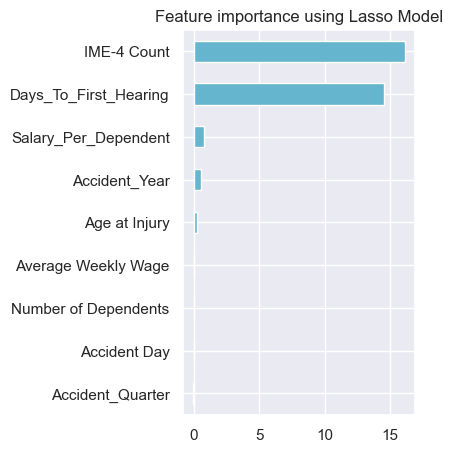

In [21]:
plot_importance(coef,'Lasso')

> ### 4.2.3. Recursive Feature Elimination - RFE <a class="anchor" id="sub_section_4_2_3"></a>

 RFE is employed here to further validate the important features as identified by LASSO. By sequentially removing the least important features, RFE helps to refine the feature set.

Observations:
The selected features after RFE likely overlap with those identified by LASSO, suggesting consistency in feature importance.
Using both LASSO and RFE provides a more robust feature selection by cross-validating the importance of individual features.

This block of code performs RFE to identify the best subset of features by iterating over a range of feature numbers. The code aims to maximize model performance on the validation set.

In [ ]:
# RFE using Logistic Regression
model = LogisticRegression()


#Use the function defined in utils.py
best_features, best_score, scores = find_optimal_features_with_rfe(
    model, 
    X_train_num_scaled, 
    y_train_encoded, 
    X_val_num_scaled, 
    y_val_encoded,
    max_features=9
)


Optimum number of features: 3
F1 Macro Score with 3 features: 0.166120


**Observations:**

The loop evaluates models with 1 to 9 features, tracking the score for each.

The output indicates that 2 features yielded the highest validation f1_score score of 0.483851.

#### Applying RFE with the Optimal Number of Features
Once the optimal number of features is identified, the RFE model is finalized with this configuration.

In [22]:
#rfscv- to select 1st the number of features we should select
model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = 2)

In [23]:
X_rfe= rfe.fit_transform(X=X_train_num_scaled, y=y_train_encoded)

This shows the results of the feature selection process, listing the features selected by RFE. The code snippet confirms which features were selected as relevant by the RFE model and displays them in a boolean Series, where True indicates the feature was selected and False means it was not.

In [24]:
selected_features = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
selected_features

Number of Dependents     False
IME-4 Count               True
Accident_Quarter         False
Accident_Year            False
Accident Day             False
Days_To_First_Hearing     True
Average Weekly Wage      False
Age at Injury            False
Salary_Per_Dependent     False
dtype: bool

> ### 4.2.4. Feature Importance - Decision Tree <a class="anchor" id="sub_section_4_2_4"></a>


In [25]:
from utils import compare_feature_importances


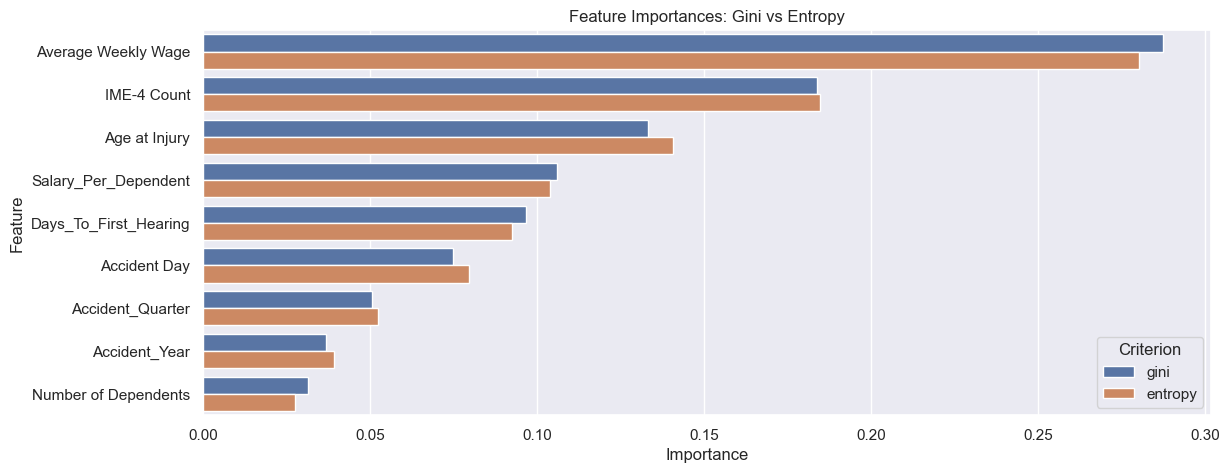

       gini   entropy                   col
0  0.031339  0.027426  Number of Dependents
1  0.183835  0.184616           IME-4 Count
2  0.050455  0.052351      Accident_Quarter
3  0.036821  0.039155         Accident_Year
4  0.074767  0.079500          Accident Day


In [26]:
# Call the function with your training data
zippy = compare_feature_importances(X_train_num_scaled, y_train_encoded)

# Access the DataFrame for further analysis if needed
print(zippy.head())

> ### 4.2.5. Feature Importance - Random Forest <a class="anchor" id="sub_section_4_2_5"></a>

In [ ]:
# Call the function with your training data
importances = compare_rf_feature_importances(X_train_num_scaled, y_train_encoded)

# Access the DataFrame for further analysis if needed
print(importances.head())

KeyboardInterrupt: 

## 4.3. Categorical Features</b> <a class="anchor" id="section_4_3"></a>
Chi-squared and MIC for the categorical ones.

 > ### $\chi ^2$ Test for Independence <a class="anchor" id="sub_section_4_2_1"></a>

 We'll apply the Chi-squared test on categorical features to check for independence. This test is suitable for categorical data and helps identify features that have significant associations with the target variable.

In [27]:
binary_columns

['Attorney/Representative', 'COVID-19 Indicator', 'Accident on Weekend']

In [28]:
#To make sure that we keep the preprocessed dataset without the encoded columns
X_train_processed_copy = X_train.copy()
X_val_processed_copy = X_val.copy()
df_test_processed_copy = df_test.copy()

In [29]:
X_train_processed_copy.shape

(398994, 38)

In [30]:
X_val_processed_copy.shape

(172208, 38)

In [31]:
X_val_processed_copy.columns

Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage', 'Birth Year', 'Carrier Name', 'Carrier Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender', 'IME-4 Count', 'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code', 'Number of Dependents', 'Category Combination', 'Carrier_District_Interaction', 'Income_Category', 'Days_To_First_Hearing', 'Accident_Quarter', 'Accident_Year', 'Accident Day', 'Accident on Weekend', 'Age Group', 'promptness_category', 'promptness_C2_category', 'promptness_C3_category', 'Zip_Code_Simplified', 'Carrier Type Merged', 'Carrier_Name_Simplified', 'Body_Part_Category', 'Injury_Nature_Category', 'Injury_Cause_Category', 'Industry Risk', 'Salary_Per_Dependent'], dtype='object')

### Approach: Encoding Categorical Features with LabelEncoder, OneHotEncoder and Frequency encoder
As our second approach we decided to perform different type of encoding according with each categorical variable. For ordinal features (those with an inherent order like age groups), Label Encoding is applied to assign each category a unique numerical value. For nominal features with low cardinality (few unique values), One-Hot Encoding is used to create binary columns representing each category. For high-cardinality features (many unique values like zip codes), Frequency Encoding is applied to convert categories to their frequency of occurrence, reducing dimensionality without introducing too many columns.

These encoding methods are used to properly represent categorical features in a numerical format while considering their characteristics (order or cardinality), which helps models interpret them effectively.

In [32]:
X_train_processed_copy['District Name'].value_counts()

District Name
NYC           188402
ALBANY         59860
HAUPPAUGE      42054
BUFFALO        31613
SYRACUSE       31149
ROCHESTER      28041
BINGHAMTON     15171
STATEWIDE       2704
Name: count, dtype: int64

In [33]:


# Example columns to encode
ordinal_features = ['promptness_category', 'promptness_C2_category','promptness_C3_category', 'Age Group', 'Income_Category', 'Industry Risk']
low_cardinality_cols = ['Gender', 'Medical Fee Region','Body_Part_Category',
       'Injury_Nature_Category', 'Injury_Cause_Category']
high_cardinality_cols = ['Carrier_Name_Simplified', 'Zip_Code_Simplified', 'Industry Code', 'County of Injury', 'Carrier Type Merged',
                         'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code','Carrier_District_Interaction', 'District Name']


# Check for NaN or nulls
print(X_val_processed_copy[ordinal_features + low_cardinality_cols + high_cardinality_cols].isnull().sum())

promptness_category               1817
promptness_C2_category            1175
promptness_C3_category            1127
Age Group                            0
Income_Category                      0
Industry Risk                        0
Gender                               0
Medical Fee Region                   0
Body_Part_Category              172208
Injury_Nature_Category            4701
Injury_Cause_Category             4695
Carrier_Name_Simplified              0
Zip_Code_Simplified                  0
Industry Code                        0
County of Injury                     0
Carrier Type Merged                  0
WCIO Cause of Injury Code            0
WCIO Nature of Injury Code           0
WCIO Part Of Body Code               0
Carrier_District_Interaction         0
District Name                        0
dtype: int64


In [34]:
#por agora antes de descobrir o erro

# Substituir os valores NaN pela moda de cada coluna

# Substituir NaNs por moda no conjunto de treino, validação e teste
for col in ordinal_features + low_cardinality_cols + high_cardinality_cols:
    # Calcular a moda da coluna no conjunto de treino
    moda = X_train_processed_copy[col].mode()[0]
    
    # Substituir NaNs nos três conjuntos de dados pela moda calculada
    X_train_processed_copy[col] = X_train_processed_copy[col].fillna(moda)
    X_val_processed_copy[col] = X_val_processed_copy[col].fillna(moda)
    df_test_processed_copy[col] = df_test_processed_copy[col].fillna(moda)

# Verificar se ainda existem valores ausentes
print(X_train_processed_copy.isnull().sum())
print(X_val_processed_copy.isnull().sum())
print(df_test_processed_copy.isnull().sum())

Age at Injury                   0
Attorney/Representative         0
Average Weekly Wage             0
Birth Year                      0
Carrier Name                    0
Carrier Type                    0
County of Injury                0
COVID-19 Indicator              0
District Name                   0
Gender                          0
IME-4 Count                     0
Industry Code                   0
Medical Fee Region              0
WCIO Cause of Injury Code       0
WCIO Nature of Injury Code      0
WCIO Part Of Body Code          0
Zip Code                        1
Number of Dependents            0
Category Combination            0
Carrier_District_Interaction    0
Income_Category                 0
Days_To_First_Hearing           0
Accident_Quarter                0
Accident_Year                   0
Accident Day                    0
Accident on Weekend             0
Age Group                       0
promptness_category             0
promptness_C2_category          0
promptness_C3_

In [35]:
df_test_processed_copy['Industry Risk'].value_counts()

Industry Risk
Unknown Risk    293128
High Risk        85111
Medium Risk       9736
Name: count, dtype: int64

In [36]:
# #por agoraaaaaaaaaa

# # Obter o valor mais frequente (moda) da coluna 'Industry Risk' no conjunto de treino
# most_frequent_value = X_train_processed_copy['Industry Risk'].mode()[0]

# # Substituir 'Unknown Risk' por esse valor no conjunto de teste
# df_test_processed_copy['Industry Risk'] = df_test_processed_copy['Industry Risk'].replace('Unknown Risk', most_frequent_value)

In [37]:
# Sum all the NaN values in the datasets
missing_values_total = (
    X_train_processed_copy.isnull().sum().sum() +
    X_val_processed_copy.isnull().sum().sum() +
    df_test_processed_copy.isnull().sum().sum()
)

print(f"Total NaN values in all  the datasets: {missing_values_total}")

Total NaN values in all  the datasets: 1


In [38]:
#For now since the pre processing isnt finish lets replace nan by 0 the row tha has nan vlaues
X_train_processed_copy = X_train_processed_copy.fillna(0)


In [39]:
# Lista de colunas a remover
columns_to_drop = ['Carrier Name', 'Carrier Type']

# Remover as colunas dos datasets
X_train_processed_copy = X_train_processed_copy.drop(columns=columns_to_drop)
X_val_processed_copy = X_val_processed_copy.drop(columns=columns_to_drop)
df_test_processed_copy = df_test_processed_copy.drop(columns=columns_to_drop)

# Verificar as alterações
print(X_train_processed_copy.head())
print(X_val_processed_copy.head())
print(df_test_processed_copy.head())


                  Age at Injury  Attorney/Representative  Average Weekly Wage  Birth Year County of Injury  COVID-19 Indicator District Name Gender  IME-4 Count  Industry Code Medical Fee Region  WCIO Cause of Injury Code  WCIO Nature of Injury Code  WCIO Part Of Body Code Zip Code  Number of Dependents Category Combination Carrier_District_Interaction      Income_Category  Days_To_First_Hearing  Accident_Quarter  Accident_Year  Accident Day  Accident on Weekend    Age Group promptness_category promptness_C2_category promptness_C3_category Zip_Code_Simplified Carrier Type Merged         Carrier_Name_Simplified   Body_Part_Category Injury_Nature_Category Injury_Cause_Category Industry Risk  Salary_Per_Dependent
Claim Identifier                                                                                                                                                                                                                                                                        

In [40]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd

# Step 1: Label Encode ordinal features (features with intrinsic order)
label_encoder_1 = LabelEncoder()
for col in ordinal_features:
    # Ensure input is a column from the DataFrame
    print(f"Processing ordinal feature: {col}")
    X_train_processed_copy[col] = label_encoder_1.fit_transform(X_train_processed_copy[col])
    X_val_processed_copy[col] = label_encoder_1.transform(X_val_processed_copy[col])
    df_test_processed_copy[col] = label_encoder_1.transform(df_test_processed_copy[col])

# Step 2: One-Hot Encode low-cardinality nominal features
print("\nProcessing low-cardinality features for One-Hot Encoding...")
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')  # Corrected argument

# Extract the subset of low-cardinality columns
low_cardinality_train = X_train_processed_copy[low_cardinality_cols]
low_cardinality_val = X_val_processed_copy[low_cardinality_cols]
low_cardinality_test = df_test_processed_copy[low_cardinality_cols]

# Apply One-Hot Encoding
one_hot_encoded_train = one_hot_encoder.fit_transform(low_cardinality_train)
one_hot_encoded_val = one_hot_encoder.transform(low_cardinality_val)
one_hot_encoded_test = one_hot_encoder.transform(low_cardinality_test)

# Verify the shapes
print("Shape of one-hot encoded train data:", one_hot_encoded_train.shape)
print("Shape of one-hot encoded val data:", one_hot_encoded_val.shape)
print("Shape of one-hot encoded test data:", one_hot_encoded_test.shape)

# Convert One-Hot Encoded arrays to DataFrames
feature_names = one_hot_encoder.get_feature_names_out(low_cardinality_cols)
one_hot_encoded_train_df = pd.DataFrame(one_hot_encoded_train, columns=feature_names, index=X_train_processed_copy.index)
one_hot_encoded_val_df = pd.DataFrame(one_hot_encoded_val, columns=feature_names, index=X_val_processed_copy.index)
one_hot_encoded_test_df = pd.DataFrame(one_hot_encoded_test, columns=feature_names, index=df_test_processed_copy.index)

# Concatenate the encoded columns with the original datasets
X_train_processed_copy = pd.concat([X_train_processed_copy, one_hot_encoded_train_df], axis=1)
X_val_processed_copy = pd.concat([X_val_processed_copy, one_hot_encoded_val_df], axis=1)
df_test_processed_copy = pd.concat([df_test_processed_copy, one_hot_encoded_test_df], axis=1)

# Drop original low-cardinality columns
X_train_processed_copy.drop(columns=low_cardinality_cols, inplace=True)
X_val_processed_copy.drop(columns=low_cardinality_cols, inplace=True)
df_test_processed_copy.drop(columns=low_cardinality_cols, inplace=True)

# Step 3: Frequency Encoding for high-cardinality nominal features
print("\nProcessing high-cardinality features for Frequency Encoding...")
for col in high_cardinality_cols:
    print(f"Encoding high-cardinality feature: {col}")
    # Frequency count based on the training data
    freq = X_train_processed_copy[col].value_counts()
    # Apply mapping to all datasets
    X_train_processed_copy[f"{col}_freq"] = X_train_processed_copy[col].map(freq).fillna(0)
    X_val_processed_copy[f"{col}_freq"] = X_val_processed_copy[col].map(freq).fillna(0)
    df_test_processed_copy[f"{col}_freq"] = df_test_processed_copy[col].map(freq).fillna(0)

# Drop original high-cardinality columns
X_train_processed_copy.drop(columns=high_cardinality_cols, inplace=True)
X_val_processed_copy.drop(columns=high_cardinality_cols, inplace=True)
df_test_processed_copy.drop(columns=high_cardinality_cols, inplace=True)

# Final datasets after encoding
X_train_final = X_train_processed_copy.copy()
X_val_final = X_val_processed_copy.copy()
X_test_final = df_test_processed_copy.copy()

# Summary
print("\nSummary of encoded datasets:")
print("Final X_train_final shape:", X_train_final.shape)
print("Final X_val_final shape:", X_val_final.shape)
print("Final X_test_final shape:", X_test_final.shape)


Processing ordinal feature: promptness_category
Processing ordinal feature: promptness_C2_category
Processing ordinal feature: promptness_C3_category
Processing ordinal feature: Age Group
Processing ordinal feature: Income_Category
Processing ordinal feature: Industry Risk

Processing low-cardinality features for One-Hot Encoding...
Shape of one-hot encoded train data: (398994, 25)
Shape of one-hot encoded val data: (172208, 25)
Shape of one-hot encoded test data: (387975, 25)

Processing high-cardinality features for Frequency Encoding...
Encoding high-cardinality feature: Carrier_Name_Simplified
Encoding high-cardinality feature: Zip_Code_Simplified
Encoding high-cardinality feature: Industry Code
Encoding high-cardinality feature: County of Injury
Encoding high-cardinality feature: Carrier Type Merged
Encoding high-cardinality feature: WCIO Cause of Injury Code
Encoding high-cardinality feature: WCIO Nature of Injury Code
Encoding high-cardinality feature: WCIO Part Of Body Code
Enc

In [41]:
X_val_final

,Age at Injury,Attorney/Representative,Average Weekly Wage,Birth Year,COVID-19 Indicator,IME-4 Count,Zip Code,Number of Dependents,Category Combination,Income_Category,Days_To_First_Hearing,Accident_Quarter,Accident_Year,Accident Day,Accident on Weekend,Age Group,promptness_category,promptness_C2_category,promptness_C3_category,Industry Risk,Salary_Per_Dependent,Gender_M,Gender_U,Medical Fee Region_II,Medical Fee Region_III,Medical Fee Region_IV,Medical Fee Region_UK,Body_Part_Category_Lower Extremities,Body_Part_Category_Multiple Body Parts,Body_Part_Category_Neck,Body_Part_Category_NonClassificable,Body_Part_Category_Trunk,Body_Part_Category_Upper Extremities,Injury_Nature_Category_Multiple Injuries,Injury_Nature_Category_Occupational Disease or Cumulative Injury,Injury_Nature_Category_Specific Injury,Injury_Cause_Category_COVID-19 Injury,"Injury_Cause_Category_Caught In, Under, or Between","Injury_Cause_Category_Cut, Puncture, Scrape","Injury_Cause_Category_Fall, Slip, or Trip",Injury_Cause_Category_Miscellaneous Causes,Injury_Cause_Category_Motor Vehicle,Injury_Cause_Category_Rubbed or Abraded by,Injury_Cause_Category_Strain or Injury By,Injury_Cause_Category_Striking Against or Stepping On,Injury_Cause_Category_Struck or Injured by,Carrier_Name_Simplified_freq,Zip_Code_Simplified_freq,Industry Code_freq,County of Injury_freq,Carrier Type Merged_freq,WCIO Cause of Injury Code_freq,WCIO Nature of Injury Code_freq,WCIO Part Of Body Code_freq,Carrier_District_Interaction_freq,District Name_freq
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5893917,0.421875,1.0,0.000538,1978.101209,0.0,0.027397,10467,0.333333,PRIVATE-M,3,0.040164,0.666667,0.967742,0.000000,0,2,1,1,1,2,0.000720,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3159.0,3049.0,21385,27559,198800,8249,1963,29320,92172.0,188402
5978089,0.671875,0.0,0.000594,1963.000000,0.0,0.000000,14094,0.500000,PRIVATE-M,0,0.025765,0.333333,0.983871,0.000000,0,0,6,6,6,2,0.000595,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1981.0,1429.0,10596,5069,198800,10225,77440,6925,17351.0,31613
5622704,0.187500,1.0,0.000442,1987.000000,0.0,0.013699,20171,0.833333,PRIVATE-M,4,0.151970,0.666667,0.870968,0.166667,0,2,5,5,5,2,0.000294,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,85478.0,282759.0,6970,21355,198800,23269,107391,26424,17351.0,31613
5774156,0.468750,1.0,0.000876,1975.000000,0.0,0.000000,11727,0.333333,PRIVATE-M,0,0.029037,0.666667,0.967742,0.666667,0,0,4,3,6,2,0.001172,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1154.0,282759.0,21385,41965,198800,8335,38955,33692,22238.0,42054
6126437,0.250000,0.0,0.000589,1990.000000,0.0,0.000000,11691,0.500000,SELF PUBLIC-F,0,0.025765,0.666667,0.983871,0.666667,0,2,0,0,6,0,0.000590,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14917.0,1009.0,64452,40411,84894,22242,25377,29320,46924.0,188402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5933260,0.203125,1.0,0.000516,1993.000000,0.0,0.000000,13325,0.500000,SIF-M,4,0.056468,0.000000,0.983871,1.000000,1,2,6,6,6,0,0.000518,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,77168.0,282759.0,64452,876,77168,25993,107391,26424,7776.0,31149
5969588,0.171875,0.0,0.000427,1995.000000,0.0,0.000000,10469,0.000000,PRIVATE-F,4,0.025765,0.333333,0.983871,0.500000,0,2,6,6,6,2,0.001729,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4491.0,1462.0,79723,27559,198800,22242,107391,798,92172.0,188402
6070626,0.421875,0.0,0.000290,1979.101209,0.0,0.

### Why Are There Missing Values (NaN) in Validation and Test Sets?

During the encoding process, missing values (NaN) may appear in the validation and test sets because certain categories that exist in these sets might not be present in the training set. For instance, during frequency encoding, if a category exists only in the validation or test set but not in the training set, it will result in missing values when encoding those rows.

To address this, we can fill these missing values with a placeholder such as `0`, ensuring consistent feature representation across all datasets, for now. For next deliverable we will try to implement better approaches.

In [42]:
# Summing all the NaN values in the datasets
missing_values_total = (
    X_train_final.isnull().sum().sum() +
    X_val_final.isnull().sum().sum() +
    X_test_final.isnull().sum().sum()
)

print(f"Total NaN sum: {missing_values_total}")

Total NaN sum: 0


In [43]:
#Prepare final dataset for MIC and χ² analysis
# Use only the encoded features for the MIC and chi-squared tests
mic_chi2_features = binary_columns + ordinal_features + list(one_hot_encoded_train_df.columns) + [f"{col}_freq" for col in high_cardinality_cols]
X_train_mic_chi2 = X_train_final[mic_chi2_features]

In [44]:
len(X_train_mic_chi2.columns)

44

In [45]:
X_train_mic_chi2.columns

Index(['Attorney/Representative', 'COVID-19 Indicator', 'Accident on Weekend', 'promptness_category', 'promptness_C2_category', 'promptness_C3_category', 'Age Group', 'Income_Category', 'Industry Risk', 'Gender_M', 'Gender_U', 'Medical Fee Region_II', 'Medical Fee Region_III', 'Medical Fee Region_IV', 'Medical Fee Region_UK', 'Body_Part_Category_Lower Extremities', 'Body_Part_Category_Multiple Body Parts', 'Body_Part_Category_Neck', 'Body_Part_Category_NonClassificable', 'Body_Part_Category_Trunk', 'Body_Part_Category_Upper Extremities', 'Injury_Nature_Category_Multiple Injuries', 'Injury_Nature_Category_Occupational Disease or Cumulative Injury', 'Injury_Nature_Category_Specific Injury', 'Injury_Cause_Category_COVID-19 Injury', 'Injury_Cause_Category_Caught In, Under, or Between', 'Injury_Cause_Category_Cut, Puncture, Scrape', 'Injury_Cause_Category_Fall, Slip, or Trip', 'Injury_Cause_Category_Miscellaneous Causes', 'Injury_Cause_Category_Motor Vehicle',
       'Injury_Cause_Category_

#### Chi-Squared Test for Feature Selection
The Chi-squared test helps us identify the most relevant categorical and binary features by evaluating their independence with the target variable. In this analysis, we set a threshold to keep the 25 most relevant features.

In [46]:
from utils import select_high_score_features_chi2_no_model


In [47]:
# Example usage
high_score_features_chi2, scores = select_high_score_features_chi2_no_model(
    X_train_mic_chi2, 
    y_train_encoded, 
    threshold=25
)

Top 25 features based on Chi-square scores: ['WCIO Nature of Injury Code_freq', 'Carrier Type Merged_freq', 'District Name_freq', 'Zip_Code_Simplified_freq', 'Industry Code_freq', 'WCIO Part Of Body Code_freq', 'Carrier_Name_Simplified_freq', 'Carrier_District_Interaction_freq', 'County of Injury_freq', 'WCIO Cause of Injury Code_freq', 'Attorney/Representative', 'promptness_C3_category', 'Income_Category', 'Injury_Cause_Category_Strain or Injury By', 'Injury_Cause_Category_Cut, Puncture, Scrape', 'Body_Part_Category_Trunk', 'promptness_C2_category', 'Body_Part_Category_Upper Extremities', 'promptness_category', 'Industry Risk', 'Age Group', 'COVID-19 Indicator', 'Injury_Cause_Category_Fall, Slip, or Trip', 'Injury_Cause_Category_COVID-19 Injury', 'Injury_Cause_Category_Motor Vehicle']
Corresponding Chi-square scores: [212491586.70222616, 94266275.39525677, 78470493.63273214, 68720608.0951044, 59692192.26503737, 52297710.57697825, 44429958.47383238, 39243249.11669883, 26182982.38754533

In [48]:
high_score_features_chi2

['WCIO Nature of Injury Code_freq',
 'Carrier Type Merged_freq',
 'District Name_freq',
 'Zip_Code_Simplified_freq',
 'Industry Code_freq',
 'WCIO Part Of Body Code_freq',
 'Carrier_Name_Simplified_freq',
 'Carrier_District_Interaction_freq',
 'County of Injury_freq',
 'WCIO Cause of Injury Code_freq',
 'Attorney/Representative',
 'promptness_C3_category',
 'Income_Category',
 'Injury_Cause_Category_Strain or Injury By',
 'Injury_Cause_Category_Cut, Puncture, Scrape',
 'Body_Part_Category_Trunk',
 'promptness_C2_category',
 'Body_Part_Category_Upper Extremities',
 'promptness_category',
 'Industry Risk',
 'Age Group',
 'COVID-19 Indicator',
 'Injury_Cause_Category_Fall, Slip, or Trip',
 'Injury_Cause_Category_COVID-19 Injury',
 'Injury_Cause_Category_Motor Vehicle']

> ### Mutual Information Criterion (MIC) for Feature Selection <a class="anchor" id="sub_section_4_2_2"></a>

The Mutual Information Criterion is used to measure the dependence between each feature and the target variable. By setting a threshold, we retain only the most relevant features.

In [49]:
from utils import select_high_score_features_MIC


In [50]:
# Example usage
high_score_features_MIC, scores_MIC = select_high_score_features_MIC(
    X_train_mic_chi2, 
    y_train_mapped, 
    threshold=25, 
    random_state=42)

NameError: name 'y_train_mapped' is not defined

### Intersection of Selected Features by Chi-squared and MIC
To identify the most relevant categorical features, we take the intersection of features selected by both Chi-squared and MIC methods.

In [ ]:
# Find common features between Chi-squared and MIC selections
common_categorical_features = list(set(high_score_features_chi2).intersection(set(high_score_features_MIC)))
features_selected = common_categorical_features  # Final list of selected features
features_selected  # Display the list of intersected features

NameError: name 'high_score_features_MIC' is not defined

## 4.4. Final Features</b> <a class="anchor" id="section_4_4"></a>



| Predictor             | Spearman                         | Pearson                  | Lasso   | RFE LR   | Decision Trees & RF Importance        | What to do? (One possible way to "solve")        |
|-----------------------|----------------------------------|--------------------------|---------|----------|----------------------------------------|--------------------------------------------------|
| Number of Dependents  | High (-0.81 with Salary/Depend) | Low                      | Discard | Discard  | Low                                    | Discard                                          |
| IME-4 Count           | High (0.85 with Days to Hear)   | Low                      | Keep    | Keep     | High                                   | Include in the model                             |
| Accident_Quarter      | Low                             | Low                      | Discard | Keep     | Low                               | Discard         |
| Accident_Year         | Low                             | Low                      | Keep    | Keep     | Low                               | Discard                            |
| Accident Day          | Low                             | Low                      | Discard | Keep     | Low                                    | Discard                                          |
| Days_To_First_Hearing | High (0.85 with IME-4 Count)    | Low                      | Keep    | Keep     | High                                   | Include in the model                             |
| Average Weekly Wage   | Moderate (0.52 with Salary/Dep) | High (0.95)              | Discard | Keep     | High                                   | Discard                             |
| Age at Injury         | Low                             | Low                      | Keep    | Keep     | High                                   | Include in the model                
| Salary_Per_Dependent  | High (-0.81 and 0.52)           | High (0.95)              | Keep (0.50)  | Keep     | High                                   | Include in the model                             |




In [51]:
final_features = [
    # Categorical features selected through MIC and chi2
    'Carrier_District_Interaction_freq',
    'Zip_Code_Simplified_freq',
    'District Name_freq',
    'COVID-19 Indicator',
    'WCIO Cause of Injury Code_freq',
    'WCIO Part Of Body Code_freq',
    'Age Group',
    'Attorney/Representative',
    'Industry Code_freq',
    'Body_Part_Category_Trunk',
    'promptness_category',
    'County of Injury_freq',
    'promptness_C2_category',
    'promptness_C3_category',
    'Body_Part_Category_Upper Extremities',
    'Carrier Type Merged_freq',
    'Industry Risk',
    'Carrier_Name_Simplified_freq',
    'Income_Category',
    'WCIO Nature of Injury Code_freq',
    'Injury_Cause_Category_Strain or Injury By',
    # Important numerical features
    'IME-4 Count', 'Salary_Per_Dependent','Days_To_First_Hearing','Age at Injury'  
]


# Extracting the final features from the processed datasets
X_train_final = X_train_processed_copy[final_features]
X_val_final = X_val_processed_copy[final_features]
X_test_final = df_test_processed_copy[final_features]

# Print the shape of the final datasets to confirm consistency
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_val_final shape: {X_val_final.shape}")
print(f"X_test_final shape: {X_test_final.shape}")

X_train_final shape: (398994, 25)
X_val_final shape: (172208, 25)
X_test_final shape: (387975, 25)


### 4. Build a Simple Model and Assess Performance
#### Problem Type and Model Selection
The problem we are dealing with is a classification problem since our goal is to predict the type of variable claim injury as our target variable. As it is a categorical variable we decided to try algorithms like Logistic Regression, Random Forest, XGBoost and other classification models. To start, a simple logistic regression was built due to its interpretability and ease of use. Moreover, it supports an effective starting point for further analysis and comparison against more complex models.

#### Cross-Validation for Performance Assessment
In order to assess the model’s performance we decided to use cross validation. This technique ensures a reliable evaluation by divding our data into multiple folds and having training/testing the model on different subsets. This really helps to avoid overfitting (which was a problem that from the beginning we identify we had) and provides a comprehensive view of how well the model generalizes to unseen data.

#### Metrics for Evaluation
For model evaluation we look into some metrics like:
Precision, Recall, and F1-Score given that our target variable is claim injury type, and the dataset has an imbalanced class distributions. 
Precision tells us how many of the predicted positive instances are actually positive, while recall shows how many of the actual positives were correctly predicted. **F1 Score* provides a balance between precision and recall, which is crucial when handling imbalanced data.
Even though accuracy can provide a general idea of overall correctness, it is not our main focus due to the class imbalance. Relying solely on accuracy could give misleading insights, as it may be high even if the model is not performing well on minority classes

With these metrics we ensure a global evaluation of the model, especially considering the facts above mentioned such as imbalanced dataset and helps guiding model improvement effectively.


# 3. Setting the Target <a class="anchor" id="chapter3"></a>

In [52]:
# Importar bibliotecas necessárias
from sklearn.ensemble import RandomForestClassifier

# Criar uma máscara booleana para valores 1, 3, 5, 6, 7 e 8 no y_train
mask_train = (y_train_encoded == 1) | (y_train_encoded == 3) | (y_train_encoded == 5) | \
             (y_train_encoded == 6) | (y_train_encoded == 7) | (y_train_encoded == 8)

# Filtrar X_train com base na máscara
X_train_1_3_5_6_7_8 = X_train_final[mask_train]
# Filtrar y_train com base na mesma máscara
y_train_1_3_5_6_7_8 = y_train_encoded[mask_train]

# Criar uma máscara booleana para valores 1, 3, 5, 6, 7 e 8 no y_val
mask_val = (y_val_encoded == 1) | (y_val_encoded == 3) | (y_val_encoded == 5) | \
           (y_val_encoded == 6) | (y_val_encoded == 7) | (y_val_encoded == 8)

# Filtrar X_val com base na máscara
X_val_1_3_5_6_7_8 = X_val_final[mask_val]
# Filtrar y_val com base na mesma máscara
y_val_1_3_5_6_7_8 = y_val_encoded[mask_val]


In [56]:
X_train_final

,Carrier_District_Interaction_freq,Zip_Code_Simplified_freq,District Name_freq,COVID-19 Indicator,WCIO Cause of Injury Code_freq,WCIO Part Of Body Code_freq,Age Group,Attorney/Representative,Industry Code_freq,Body_Part_Category_Trunk,promptness_category,County of Injury_freq,promptness_C2_category,promptness_C3_category,Body_Part_Category_Upper Extremities,Carrier Type Merged_freq,Industry Risk,Carrier_Name_Simplified_freq,Income_Category,WCIO Nature of Injury Code_freq,Injury_Cause_Category_Strain or Injury By,IME-4 Count,Salary_Per_Dependent,Days_To_First_Hearing,Age at Injury
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,
5479022,7776,282759,31149,0.0,8335,17460,3,0.0,1674,0.0,6,3199,6,6,0.0,77168,2,77168,1,107391,1.0,0.000000,0.000284,0.025765,0.125000
6023025,92172,1853,188402,0.0,22242,3732,2,1.0,7076,0.0,0,40411,0,0,0.0,198800,2,85478,2,77440,0.0,0.054795,0.000512,0.032369,0.312500
5851908,13876,282759,28041,0.0,32701,26424,2,1.0,12137,0.0,1,16669,1,1,1.0,198800,2,10057,1,107391,1.0,0.027397,0.000216,0.065869,0.390625
5913931,29045,1095,59860,0.0,8447,6925,0,1.0,7076,0.0,6,9560,6,6,1.0,198800,2,10057,2,38955,0.0,0.027397,0.000732,0.042663,0.671875
5845976,92172,1608,188402,0.0,20446,15882,0,0.0,79723,0.0,0,37121,0,6,0.0,198800,2,2078,4,8939,0.0,0.000000,0.000284,0.025765,0.656250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5655355,22238,282759,42054,1.0,17547,9818,1,0.0,30501,1.0,4,41965,3,6,0.0,198800,2,8924,1,18028,0.0,0.000000,0.000292,0.025765,0.781250
5940234,14520,282759,59860,0.0,25993,29320,2,1.0,64452,0.0,4,3569,4,3,0.0,77168,0,77168,0,77440,0.0,0.000000,0.000708,0.025765,0.296875
6073417,15496,282759,31149,0.0,32701,33692,0,1.0,12137,0.0,3,10851,3,1,0.0,198800,2,6349,0,38955,1.0,0.027397,0.003154,0.025765,0.625000


In [54]:
from sklearn.preprocessing import LabelEncoder

# Reindexar as classes
le = LabelEncoder()

# Ajustar e transformar as classes de treinamento e validação
y_train_encoded = le.fit_transform(y_train_1_3_5_6_7_8)
y_val_encoded = le.transform(y_val_1_3_5_6_7_8)

# Treinar o modelo XGBoost
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), 
                          random_state=42, n_estimators=200, learning_rate=0.1, max_depth=6)
xgb_model.fit(X_train_1_3_5_6_7_8, y_train_encoded)

# Fazer previsões
val_predictions_xgb = xgb_model.predict(X_val_1_3_5_6_7_8)

# Decodificar as previsões de volta para os rótulos originais
val_predictions_decoded = le.inverse_transform(val_predictions_xgb)

# Avaliar o desempenho
val_accuracy_xgb = accuracy_score(y_val_1_3_5_6_7_8, val_predictions_decoded)
print(f"Acurácia no conjunto de validação com XGBoost: {val_accuracy_xgb:.4f}")

# Relatório de Classificação
print("\nRelatório de Classificação (XGBoost):")
print(classification_report(y_val_1_3_5_6_7_8, val_predictions_decoded))

# Matriz de Confusão
print("\nMatriz de Confusão (XGBoost):")
print(confusion_matrix(y_val_1_3_5_6_7_8, val_predictions_decoded))




Acurácia no conjunto de validação com XGBoost: 0.8080

Relatório de Classificação (XGBoost):
              precision    recall  f1-score   support

           1       0.92      0.71      0.80      3743
           3       0.89      0.79      0.84     20672
           5       0.71      0.93      0.81     14484
           6       0.58      0.03      0.05      1263
           7       0.00      0.00      0.00        29
           8       0.83      0.37      0.51       141

    accuracy                           0.81     40332
   macro avg       0.65      0.47      0.50     40332
weighted avg       0.82      0.81      0.80     40332


Matriz de Confusão (XGBoost):
[[ 2650   933   157     0     0     3]
 [  208 16404  4040    12     0     8]
 [   23  1002 13446    13     0     0]
 [    0    73  1154    36     0     0]
 [    0     5    23     1     0     0]
 [    8    62    19     0     0    52]]


In [57]:
from sklearn.ensemble import RandomForestClassifier

# Treinar o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
rf_model.fit(X_train_1_3_5_6_7_8, y_train_1_3_5_6_7_8)

# Fazer previsões
val_predictions_rf = rf_model.predict(X_val_1_3_5_6_7_8)

# Avaliar o desempenho
val_accuracy_rf = accuracy_score(y_val_1_3_5_6_7_8, val_predictions_rf)
print(f"Acurácia no conjunto de validação com Random Forest: {val_accuracy_rf:.4f}")

# Relatório de Classificação
print("\nRelatório de Classificação (Random Forest):")
print(classification_report(y_val_1_3_5_6_7_8, val_predictions_rf))

# Matriz de Confusão
print("\nMatriz de Confusão (Random Forest):")
print(confusion_matrix(y_val_1_3_5_6_7_8, val_predictions_rf))



Acurácia no conjunto de validação com Random Forest: 0.7815

Relatório de Classificação (Random Forest):
              precision    recall  f1-score   support

           1       0.97      0.63      0.76      3743
           3       0.88      0.76      0.81     20672
           5       0.67      0.93      0.78     14484
           6       1.00      0.00      0.00      1263
           7       0.00      0.00      0.00        29
           8       1.00      0.04      0.08       141

    accuracy                           0.78     40332
   macro avg       0.75      0.39      0.41     40332
weighted avg       0.82      0.78      0.77     40332


Matriz de Confusão (Random Forest):
[[ 2358  1091   294     0     0     0]
 [   69 15741  4862     0     0     0]
 [    8  1062 13414     0     0     0]
 [    0    28  1234     1     0     0]
 [    0     1    28     0     0     0]
 [    4    66    65     0     0     6]]


In [58]:
from sklearn.neural_network import MLPClassifier

# Treinar o modelo MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
mlp_model.fit(X_train_1_3_5_6_7_8, y_train_1_3_5_6_7_8)

# Fazer previsões
val_predictions_mlp = mlp_model.predict(X_val_1_3_5_6_7_8)

# Avaliar o desempenho
val_accuracy_mlp = accuracy_score(y_val_1_3_5_6_7_8, val_predictions_mlp)
print(f"Acurácia no conjunto de validação com MLP: {val_accuracy_mlp:.4f}")

# Relatório de Classificação
print("\nRelatório de Classificação (MLP):")
print(classification_report(y_val_1_3_5_6_7_8, val_predictions_mlp))

# Matriz de Confusão
print("\nMatriz de Confusão (MLP):")
print(confusion_matrix(y_val_1_3_5_6_7_8, val_predictions_mlp))


Acurácia no conjunto de validação com MLP: 0.5372

Relatório de Classificação (MLP):
              precision    recall  f1-score   support

           1       0.95      0.01      0.01      3743
           3       0.53      0.98      0.68     20672
           5       0.71      0.10      0.18     14484
           6       0.00      0.00      0.00      1263
           7       0.00      0.00      0.00        29
           8       0.00      0.00      0.00       141

    accuracy                           0.54     40332
   macro avg       0.36      0.18      0.15     40332
weighted avg       0.61      0.54      0.42     40332


Matriz de Confusão (MLP):
[[   21  3662    60     0     0     0]
 [    1 20167   504     0     0     0]
 [    0 13007  1477     0     0     0]
 [    0  1211    52     0     0     0]
 [    0    29     0     0     0     0]
 [    0   141     0     0     0     0]]


In [ ]:
# Filtrar linhas em que y_test == 0
X_test_target = X_test_final[y_test == 0]

# Remover a coluna 'Final_Predictions' se ela existir nos dados de entrada
X_test_target = X_test_target.drop(columns=['Final_Predictions'], errors='ignore')

# Fazer previsões nas linhas filtradas
test_target_predictions_encoded = xgb_model.predict(X_test_target)

# Decodificar as previsões para os rótulos originais
test_target_predictions = le.inverse_transform(test_target_predictions_encoded)

# Adicionar as previsões ao dataset de teste
X_test_final.loc[y_test == 0, 'Final_Predictions'] = test_target_predictions



Final_Predictions
3.0    161111
1.0      8197
5.0      5111
6.0       479
8.0        72
Name: count, dtype: int64


In [66]:
# Adicionar y_test ao DataFrame X_test_final
X_test_final['Predictions'] = y_test.values


In [67]:
X_test_final

,Carrier_District_Interaction_freq,Zip_Code_Simplified_freq,District Name_freq,COVID-19 Indicator,WCIO Cause of Injury Code_freq,WCIO Part Of Body Code_freq,Age Group,Attorney/Representative,Industry Code_freq,Body_Part_Category_Trunk,promptness_category,County of Injury_freq,promptness_C2_category,promptness_C3_category,Body_Part_Category_Upper Extremities,Carrier Type Merged_freq,Industry Risk,Carrier_Name_Simplified_freq,Income_Category,WCIO Nature of Injury Code_freq,Injury_Cause_Category_Strain or Injury By,IME-4 Count,Salary_Per_Dependent,Days_To_First_Hearing,Age at Injury,Final_Predictions,Predictions
0,92172.0,1614.0,188402,0,22242,8131,3,0,26025,0.0,3,27559,3,6,0.0,198800,2,6349.0,4,77440,0.0,0.0,0.000876,0.025765,0.046875,3.0,0
1,92172.0,1009.0,188402,0,12748,5519,3,0,12655,0.0,0,40411,0,6,0.0,198800,2,7733.0,1,77440,0.0,0.0,0.000568,0.025765,0.046875,3.0,0
2,92172.0,282759.0,188402,0,7560,798,0,0,14772,1.0,6,17914,6,6,0.0,198800,2,85478.0,2,38955,0.0,0.0,0.001322,0.025765,0.671875,3.0,0
3,92172.0,282759.0,188402,0,8464,33692,2,0,26025,0.0,6,40411,6,6,0.0,198800,2,10057.0,4,77440,0.0,0.0,0.000247,0.025765,0.421875,3.0,0
4,92172.0,1816.0,188402,0,8648,8682,3,0,235,0.0,3,37121,3,6,1.0,198800,2,8924.0,4,32898,0.0,0.0,0.000282,0.025765,0.140625,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387970,7776.0,282759.0,31149,0,8122,9113,0,0,5248,0.0,5,2231,0,6,1.0,77168,2,77168.0,4,8133,1.0,0.0,0.000284,0.025765,0.562500,NaN,1
387971,10871.0,282759.0,42054,0,8122,9113,0,1,5248,0.0,3,41965,4,7,1.0,84894,2,5790.0,4,8133,1.0,0.0,0.000862,0.025765,0.671875,NaN,1
387972,33910.0,1853.0,188402,0,8122,9113,2,1,5248,0.0,4,40411,4,6,1.0,77168,2,77168.0,4,8133,1.0,0.0,0.000284,0.025765,0.453125,NaN,1
387973,14924.0,282759.0,188402,0,8122,9113,2,1,5248,0.0,1,40411,4,0,1.0,36441,2,5067.0,4,8133,1.0,0.0,0.000284,0.025765,0.421875,NaN,1
